# Thư viện

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

from graph import keypoints
from model_resgcn import ResGCN
from data import ProcessDataset
from augmentation import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [3]:
file_name = "casia-b_pose_test.csv"  
csv_path = os.path.join("..", "data", file_name)

In [4]:
transforms = TransformCompose([
    # InterpolateFrames(probability=1.0)
    # FlipSequence()
    # ShuffleSequence(enabled=True)
])

# dataset = ProcessDataset(csv_path=csv_path, transform=transforms)
dataset = ProcessDataset(csv_path=csv_path)

In [5]:
print("Dataset size:", len(dataset))

# sample = dataset[0]
# sample

Dataset size: 5406


# Đánh giá mô hình

## Tạo embedding vector với model

### Khởi tạo model

In [6]:
model = ResGCN()

In [7]:
checkpoint_dir = os.path.join(os.getcwd(), '..', 'save') 
best_checkpoint = os.path.join(checkpoint_dir, "best_checkpoint2.pth")

# Nếu checkpoint đã tồn tại thì load
if os.path.exists(best_checkpoint):
    checkpoint = torch.load(best_checkpoint, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    start_epoch = checkpoint['epoch'] 
    best_loss = checkpoint['best_loss']
    print(f"Loaded checkpoint from epoch {start_epoch} with best loss {best_loss:.4f}")
else:
    print("No checkpoint found, starting testing from original model.")

Loaded checkpoint from epoch 100 with best loss 0.8379


### Tạo embedding vector

In [8]:
def generate_embeddings(subject_id_max=124):
    condition_map = {"nm": 0, "bg": 1, "cl": 2}
    embeddings = {}
    
    for i in range(len(dataset)):
        data = dataset[i]
        subject_id = data['subject_id']
        condition = data['condition']
        condition_index = data['condition_index']
        angle = data['angle']
        node_features = data['node_features']

        if subject_id > subject_id_max:  # Chỉ lấy một vài người đầu tiên
            continue

        emb_vector = model(node_features)  # output: (1, 128)

        condition_type = condition_map[condition]
        key = (subject_id, condition_type, condition_index, angle)
        embeddings[key] = emb_vector.squeeze(0).detach().cpu().numpy()  # Lưu vector (128,)

    return embeddings

In [9]:
embeddings = generate_embeddings()

## Chia gallery, probe

In [10]:
def split_gallery_probe(embeddings):
    gallery = {}
    probe = {}

    for key, value in embeddings.items():
        subject_id, condition_type, condition_index, angle = key

        # NM 1–4
        if condition_type == 0 and condition_index <= 4:
            gallery_key = (subject_id, condition_type, condition_index, angle)
            gallery[gallery_key] = value  # Embedding vector là value
        # NM 5–6, BG 1-2, CL 1-2
        else: 
            probe_key = (subject_id, condition_type, condition_index, angle)
            probe[probe_key] = value 

    return gallery, probe

## Evaluate

### Gộp góc - Chỉ id và góc

In [11]:
def evaluate(embeddings):
    gallery, probe = split_gallery_probe(embeddings)

    y_true = []
    y_pred = []

    correct_matrix = np.zeros((11, 11))
    total_matrix = np.zeros((11, 11))

    for probe_key, probe_vec in probe.items():
        probe_subject, _, _, probe_angle = probe_key
        probe_pos = int(probe_angle / 18)

        min_distance = float('inf')
        predicted_subject = None

        # Lấy các gallery vector ở khác góc
        for gallery_key, gallery_vec in gallery.items():
            gallery_subject, _, _, gallery_angle = gallery_key
            gallery_pos = int(gallery_angle / 18)

            if gallery_angle == probe_angle:
                continue # Bỏ qua cùng góc nhìn
        
            distance = np.linalg.norm(gallery_vec - probe_vec)
            if distance < min_distance:
                min_distance = distance
                predicted_subject = gallery_subject
                selected_gallery_pos = gallery_pos

        if predicted_subject is not None:
            y_true.append(probe_subject)
            y_pred.append(predicted_subject)
            if predicted_subject == probe_subject:
                correct_matrix[selected_gallery_pos, probe_pos] += 1
            total_matrix[selected_gallery_pos, probe_pos] += 1

    acc_matrix = correct_matrix / np.clip(total_matrix, 1, None)
    acc = np.sum(correct_matrix) / np.sum(total_matrix)
    
    return acc, y_true, y_pred, acc_matrix


In [12]:
acc1, y_true1, y_pred1, acc_matrix1 = evaluate(embeddings)
print(f"Accuracy: {acc1:.4f}")
print(len(y_true1))

Accuracy: 0.6636
3261


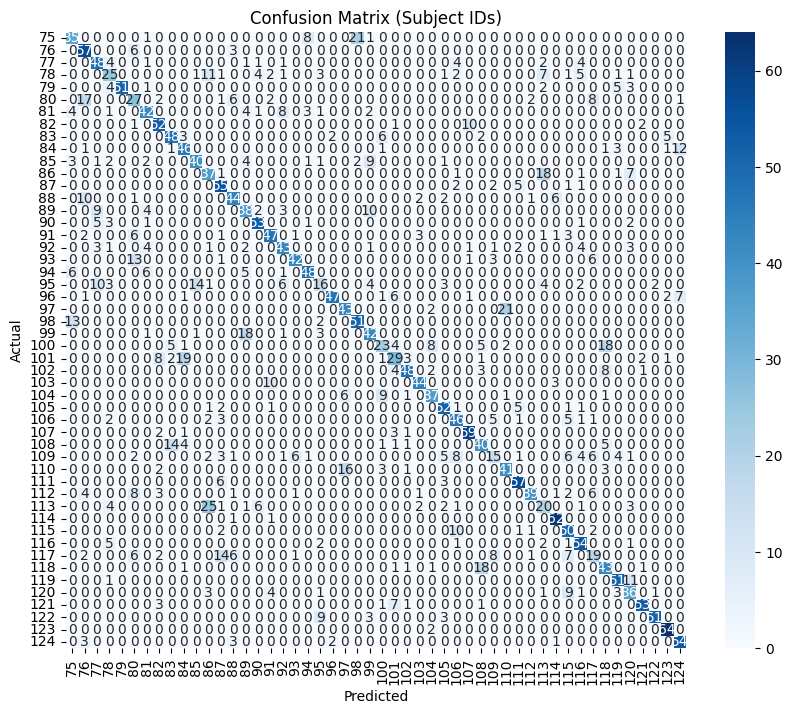

In [13]:
def plot_confusion_matrix(y_true, y_pred):
    labels = sorted(list(set(y_true + y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Subject IDs)")
    plt.show()

plot_confusion_matrix(y_true1, y_pred1)

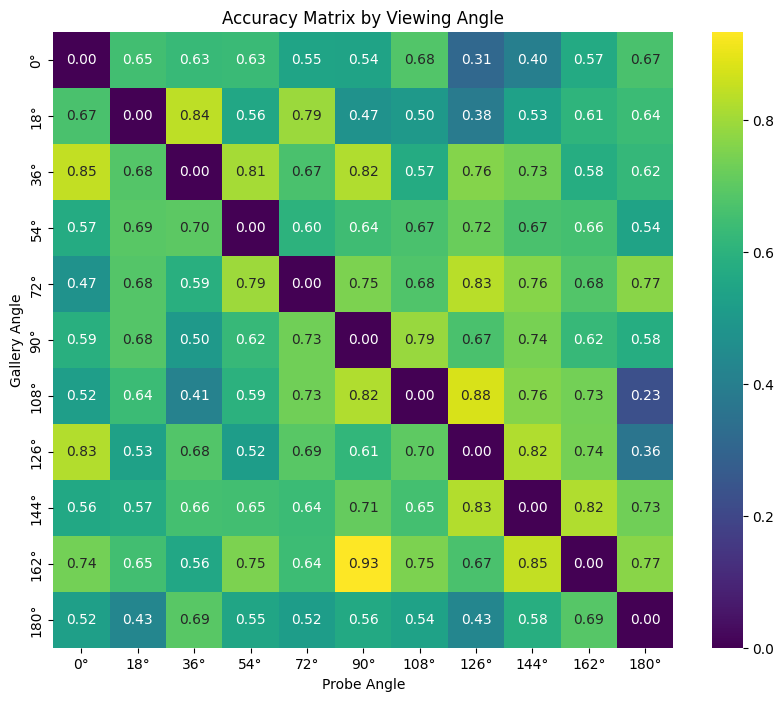

In [14]:
angles = [f"{i}°" for i in range(0, 181, 18)]

plt.figure(figsize=(10, 8))
sns.heatmap(acc_matrix1, xticklabels=angles, yticklabels=angles, annot=True, fmt=".2f", cmap="viridis")
plt.xlabel("Probe Angle")
plt.ylabel("Gallery Angle")
plt.title("Accuracy Matrix by Viewing Angle")
plt.show()

### Gộp góc - Đầy đủ id, condition, góc

In [15]:
def evaluate_full(embeddings):
    gallery, probe = split_gallery_probe(embeddings)

    y_true = []
    y_pred = []

    # Tạo 3 ma trận cho từng điều kiện: nm, bg, cl
    correct_matrix = np.zeros((3, 11, 11))
    total_matrix = np.zeros((3, 11, 11))

    for probe_key, probe_vec in probe.items():
        probe_subject, probe_condition, _, probe_angle = probe_key
        probe_pos = int(probe_angle / 18)

        min_distance = float('inf')
        predicted_subject = None

        selected_gallery_pos = None

        for gallery_key, gallery_vec in gallery.items():
            gallery_subject, _, _, gallery_angle = gallery_key
            gallery_pos = int(gallery_angle / 18)

            if gallery_angle == probe_angle:
                continue

            distance = np.linalg.norm(gallery_vec - probe_vec)
            if distance < min_distance:
                min_distance = distance
                predicted_subject = gallery_subject
                selected_gallery_pos = gallery_pos

        if predicted_subject is not None:
            y_true.append(probe_subject)
            y_pred.append(predicted_subject)
            if predicted_subject == probe_subject:
                correct_matrix[probe_condition, selected_gallery_pos, probe_pos] += 1
            total_matrix[probe_condition, selected_gallery_pos, probe_pos] += 1

    acc_matrix = correct_matrix / np.clip(total_matrix, 1, None)
    acc = np.sum(correct_matrix) / np.sum(total_matrix)

    return acc, y_true, y_pred, acc_matrix, correct_matrix, total_matrix

In [16]:
acc, y_true, y_pred, acc_matrix, correct_matrix, total_matrix = evaluate_full(embeddings)

condition_names = ["NM#5-6", "BG#1-2", "CL#1-2"]

for i, name in enumerate(condition_names):
    total_correct = np.sum(correct_matrix[i])
    total_count = np.sum(total_matrix[i])
    acc_cond = total_correct / total_count if total_count != 0 else 0
    print(f"Độ chính xác của {name}: {acc_cond:.4f}")
print(int(np.sum(total_matrix)))
print(len(y_true))

Độ chính xác của NM#5-6: 0.7996
Độ chính xác của BG#1-2: 0.6103
Độ chính xác của CL#1-2: 0.5806
3261
3261


In [17]:
correct_per_condition_probe = correct_matrix.sum(axis=1)  # (3, 11)
total_per_condition_probe = total_matrix.sum(axis=1)
accuracy_per_condition_probe = correct_per_condition_probe / np.clip(total_per_condition_probe, 1, None)

angles = [f"{a}°" for a in range(0, 181, 18)]

# Tạo bảng độ chính xác
accuracy_data = []

for i in range(len(condition_names)):
    # Lấy độ chính xác cho mỗi góc của từng điều kiện
    # accuracy_row = acc_matrix[i]
    accuracy_row = accuracy_per_condition_probe[i]
    accuracy_data.append(accuracy_row)

# Chuyển đổi thành DataFrame
df_accuracy = pd.DataFrame(accuracy_per_condition_probe, index=condition_names, columns=angles)

# Thêm cột Mean
df_accuracy["Mean"] = df_accuracy.mean(axis=1)

# In ra bảng độ chính xác
print(df_accuracy.round(2))

          0°   18°   36°   54°   72°   90°  108°  126°  144°  162°  180°  Mean
NM#5-6  0.72  0.76  0.77  0.80  0.86  0.86  0.85  0.82  0.80  0.81  0.76  0.80
BG#1-2  0.60  0.66  0.61  0.63  0.57  0.63  0.58  0.60  0.66  0.65  0.54  0.61
CL#1-2  0.58  0.48  0.52  0.56  0.57  0.63  0.61  0.65  0.67  0.56  0.56  0.58


### Theo từng góc

In [18]:
def split_gallery_probe_detail(embeddings):
    gallery = {}
    probe_nm = {}
    probe_bg = {}
    probe_cl = {}

    for key, value in embeddings.items():
        subject_id, condition, condition_index, angle = key

        if condition == 0 and condition_index <= 4:
            gallery_key = (subject_id, condition, condition_index, angle)
            gallery[gallery_key] = value
        elif condition == 0 and condition_index >= 5:
            probe_key = (subject_id, condition, condition_index, angle)
            probe_nm[probe_key] = value
        elif condition == 1:
            probe_key = (subject_id, condition, condition_index, angle)
            probe_bg[probe_key] = value
        elif condition == 2:
            probe_key = (subject_id, condition, condition_index, angle)
            probe_cl[probe_key] = value

    return gallery, probe_nm, probe_bg, probe_cl


In [21]:
def evaluate_angle(embeddings):

    gallery, probe_nm, probe_bg, probe_cl = split_gallery_probe_detail(embeddings)

    # print(f"Gallery samples: {len(gallery)}")
    # print(f"probe_nm samples: {len(probe_nm)}")
    # print(f"probe_bg samples: {len(probe_bg)}")
    # print(f"probe_cl samples: {len(probe_cl)}")

    gallery_per_angle = {}
    for angle in range(0, 181, 18):
        gallery_per_angle[angle] = {k: v for (k, v) in gallery.items() if k[3] == angle}

    correct = np.zeros((3, 11, 11))
    total = np.zeros((3, 11, 11))

    for gallery_angle in range(0, 181, 18):
        gallery_embeddings = np.array(list(gallery_per_angle[gallery_angle].values()))
        gallery_targets = list(gallery_per_angle[gallery_angle].keys())
        gallery_pos = int(gallery_angle / 18)

        probe_num = 0
        for probe in [probe_nm, probe_bg, probe_cl]:
            for (target, embedding) in probe.items():
                subject_id, _, _, probe_angle = target
                probe_pos = int(probe_angle / 18)

                distance = np.linalg.norm(gallery_embeddings - embedding, ord=2, axis=1)
                min_pos = np.argmin(distance)
                min_target = gallery_targets[int(min_pos)]

                if min_target[0] == subject_id:
                    correct[probe_num, gallery_pos, probe_pos] += 1
                total[probe_num, gallery_pos, probe_pos] += 1

            probe_num += 1

    accuracy = correct / total

    # Exclude same view (trừ kết quả khi gallery và probe cùng góc)
    for i in range(3):
        accuracy[i] -= np.diag(np.diag(accuracy[i]))

    accuracy_flat = np.sum(accuracy, 1) / 10  # trung bình theo gallery angle

    header = ["NM#5-6", "BG#1-2", "CL#1-2"]

    accuracy_avg = np.mean(accuracy)
    sub_accuracies_avg = np.mean(accuracy_flat, 1)
    sub_accuracies = dict(zip(header, list(sub_accuracies_avg)))

    # Tạo dataframe 3 hàng x 12 cột: 11 góc + mean
    dataframe = pd.DataFrame(
        data=np.concatenate((accuracy_flat, sub_accuracies_avg[..., np.newaxis]), 1),
        index=header,
        columns=[f"{angle}°" for angle in range(0, 181, 18)] + ["mean"]
    )

    return correct, accuracy_avg, sub_accuracies, dataframe

In [22]:
correct, accuracy_avg, sub_accuracies, dataframe = evaluate_angle(embeddings)

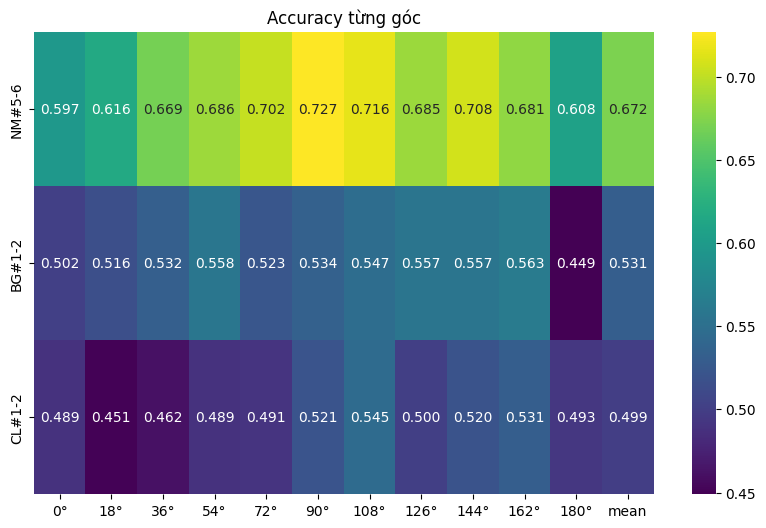

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(dataframe, annot=True, fmt=".3f", cmap='viridis', cbar=True)
plt.title("Accuracy từng góc")
plt.show()